# RelativisticDynamics.jl demo

This notebook demonstrates how to use the `RelativisticDynamics.jl` package

In [2]:
using Revise
using RelativisticDynamics

Welcome to the Relativistic Dynamics module!

---

## 1. Example Orbital Trajectory

The core aim of `RelativisticDynamics.jl` is to be able to accurately describe the spin-orbital evolution of a relativistic system. This can be easily done using the default settings as:

In [5]:
solution,model = orbit();
#PlotTrajectory(solution,model,[1,2])

THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out


(SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothin

In [14]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...


   Installed GR_jll ────────────── v0.72.7+0


   Installed RecipesPipeline ───── v0.6.12
   Installed ConcurrentUtilities ─ v2.2.0
   Installed OpenSSL ───────────── v1.4.1
   Installed PlotUtils ─────────── v1.3.5
   Installed DelimitedFiles ────── v1.9.1
   Installed Unitful ───────────── v1.14.0


   Installed Zstd_jll ──────────── v1.5.5+0


   Installed TranscodingStreams ── v0.9.13


   Installed OpenSSL_jll ───────── v1.1.21+0
   Installed HTTP ──────────────── v1.9.6


   Installed Latexify ──────────── v0.16.0
   Installed Plots ─────────────── v1.38.15


   Installed UnitfulLatexify ───── v1.6.3


   Installed GR ────────────────── v0.72.7


   Installed ColorSchemes ──────── v3.21.0


    Updating 

`~/github_repos/RelativisticDynamics.jl/Project.toml`
  [91a5bcdd] + Plots v1.38.15
    Updating `~/github_repos/RelativisticDynamics.jl/Manifest.toml`


  [d1d4a3ce] + BitFlags v0.1.7
  [944b1d66] + CodecZlib v0.7.1
  [35d6a980] + ColorSchemes v3.21.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.9.10
  [5ae59095] + Colors v0.12.10
  [f0e56b4a] + ConcurrentUtilities v2.2.0
  [d38c429a] + Contour v0.6.2
  [8bb1440f] + DelimitedFiles v1.9.1
  [c87230d0] + FFMPEG v0.4.1
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.72.7
  [42e2da0e] + Grisu v1.0.2
  [cd3eb016] + HTTP v1.9.6
  [1019f520] + JLFzf v0.1.5
  [682c06a0] + JSON v0.21.4
  [23fbe1c1] + Latexify v0.16.0
  [e6f89c97] + LoggingExtras v1.0.0
  [739be429] + MbedTLS v1.1.7
  [442fdcdd] + Measures v0.3.2
  [4d8831e6] + OpenSSL v1.4.1
  [69de0a69] + Parsers v2.5.10
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotUtils v1.3.5
  [91a5bcdd] + Plots v1.38.15
  [01d81517] + RecipesPipeline v0.6.12
  [05181044] + RelocatableFolders v1.0.0
  [6c6a2e73] + Scratch v1.2.0
  [992d4aef] + Showoff v1.

Precompiling 

project...


  ✓ Scratch


  ✓ Libmount_jll
  ✓ Xorg_libXau_jll


  ✓ DelimitedFiles
  ✓ Graphite2_jll


  ✓ OpenSSL_jll
  ✓ Bzip2_jll
  ✓ libfdk_aac_jll


  ✓ libpng_jll


  ✓ ConcurrentUtilities


  ✓ TranscodingStreams


  ✓ LAME_jll
  ✓ Pixman_jll
  ✓ Xorg_libXdmcp_jll


  ✓ LERC_jll
  ✓ fzf_jll


  ✓ Ogg_jll
  ✓ JpegTurbo_jll
  ✓ x265_jll


  ✓ x264_jll


  ✓ libaom_jll


  ✓ Zstd_jll


  ✓ Xorg_xtrans_jll
  ✓ Expat_jll
  ✓ LZO_jll


  ✓ Opus_jll
  ✓ Libiconv_jll
  ✓ Wayland_protocols_jll
  ✓ Xorg_libpthread_stubs_jll


  ✓ Libffi_jll
  ✓ Libgpg_error_jll


  ✓ FriBidi_jll


  ✓ Libuuid_jll


  ✓ RelocatableFolders


  ✓ CodecZlib


  ✓ FreeType2_jll
  ✓ libvorbis_jll
  ✓ Libtiff_jll


  ✓ JLFzf


  ✓ XML2_jll


  ✓ Libgcrypt_jll


  ✓ Fontconfig_jll
  ✓ Wayland_jll
  ✓ Latexify


  ✓ Gettext_jll


  ✓ XSLT_jll


  ✓ Zygote → ZygoteColorsExt


  ✓ Glib_jll
  ✓ Xorg_libxcb_jll


  ✓ OpenSSL


  ✓ Xorg_xcb_util_jll


  ✓ Xorg_libX11_jll


  ✓ Xorg_xcb_util_renderutil_jll
  ✓ Xorg_xcb_util_keysyms_jll
  ✓ Xorg_xcb_util_image_jll
  ✓ Xorg_xcb_util_wm_jll
  ✓ Xorg_libxkbfile_jll
  ✓ Xorg_libXrender_jll
  ✓ Xorg_libXext_jll
  ✓ Xorg_libXfixes_jll


  ✓ ColorVectorSpace


  ✓ Xorg_libXrandr_jll
  ✓ Xorg_xkbcomp_jll
  ✓ Xorg_libXcursor_jll
  ✓ Xorg_libXi_jll
  ✓ Xorg_libXinerama_jll
  ✓ Libglvnd_jll


  ✓ Cairo_jll


  ✓ Xorg_xkeyboard_config_jll
  ✓ GLFW_jll


  ✓ HarfBuzz_jll


  ✓ xkbcommon_jll


  ✓ libass_jll


  ✓ HTTP


  ✓ Qt5Base_jll


  ✓ FFMPEG_jll


  ✓ FFMPEG


  ✓ GR_jll


  ✓ ColorSchemes


  ✓ GR


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ RecipesPipeline


  ✓ Unitful


  ✓ UnitfulLatexify


  ✓ DiffEqBase → DiffEqBaseUnitfulExt


  ✓ Plots


  ✓ Plots → UnitfulExt


  ✗ RelativisticDynamics
  88 dependencies successfully precompiled in 138 seconds. 200 already precompiled.
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


In [15]:
using Plots 

In [12]:
plot(solution)

UndefVarError: UndefVarError: `plot` not defined

In [11]:
solution

retcode: Success
Interpolation: 3rd order Hermite
t: 239-element Vector{Float64}:
     0.0
     0.0013706836712055288
     0.015077520383260816
     0.1521458875038137
     1.5228295587093423
     6.418067518434445
    15.224953090589668
    27.472617582779804
    45.13144384885739
    68.65971431337698
     ⋮
 21160.580700000744
 21229.316257914248
 21306.706788038744
 21396.34823817363
 21505.739848668054
 21644.1260468004
 21830.63318431371
 22072.21133566549
 22214.414690791833
u: 239-element Vector{Vector{Float64}}:
 [0.0, 50.0, 1.5707963267948966, 0.0, 3.6099649378298974e-7, 2.3936235343199422e-8, 7.763224048232442e-10, 4.4878460714554864e-10, -3.0315904846625962e-15, 2.4838592692165083e-14, -8.604340906267791e-16, 0.0]
 [0.0014137485144900123, 50.000093739933966, 1.570799367053322, 1.757544511061177e-6, 3.609964655937437e-7, 2.393619150013512e-8, 7.763194939338126e-10, 4.487829232719859e-10, -3.0316049921986426e-15, 2.483846974181651e-14, -8.604339877973518e-16, -8.7367394841687

In [8]:
import Pkg; Pkg.add("RecipesBase")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


    Updating `~/github_repos/RelativisticDynamics.jl/Project.toml`
  [3cdcf5f2] + RecipesBase v1.3.4
  No Changes to `~/github_repos/RelativisticDynamics.jl/Manifest.toml`


In [9]:
using RecipesBase

In [6]:
@recipe function f(r::Result; ε_max = 0.5)
    # set a default value for an attribute with `-->`
    xlabel --> "x"
    ylabel --> "y"
    markershape --> :diamond
    # add a series for an error band
    @series begin
        # force an argument with `:=`
        seriestype := :path
        # ignore series in legend and color cycling
        primary := false
        linecolor := nothing
        fillcolor := :lightgray
        fillalpha := 0.5
        fillrange := r.y .- r.ε
        # ensure no markers are shown for the error band
        markershape := :none
        # return series data
        r.x, r.y .+ r.ε
    end
    # get the seriescolor passed by the user
    c = get(plotattributes, :seriescolor, :auto)
    # highlight big errors, otherwise use the user-defined color
    markercolor := ifelse.(r.ε .> ε_max, :red, c)
    # return data
    r.x, r.y
end

LoadError: LoadError: UndefVarError: `@recipe` not defined
in expression starting at /Users/t1/github_repos/RelativisticDynamics.jl/notebooks/demo.ipynb:1

---

## 2. Flexible number format

How do the solutions compare using different number formats?

In [3]:
solutionF64,modelF64 = orbit(NF=Float64);
solutionF32,modelF32 = orbit(NF=Float32);


UndefVarError: UndefVarError: orbit not defined

In [ ]:
1+1

See also Posits, Stochastic rounding, DoubleFloats.jl, ArbNumerics.jl e.g. https://tutorials.sciml.ai/html/type_handling/01-number_types.html



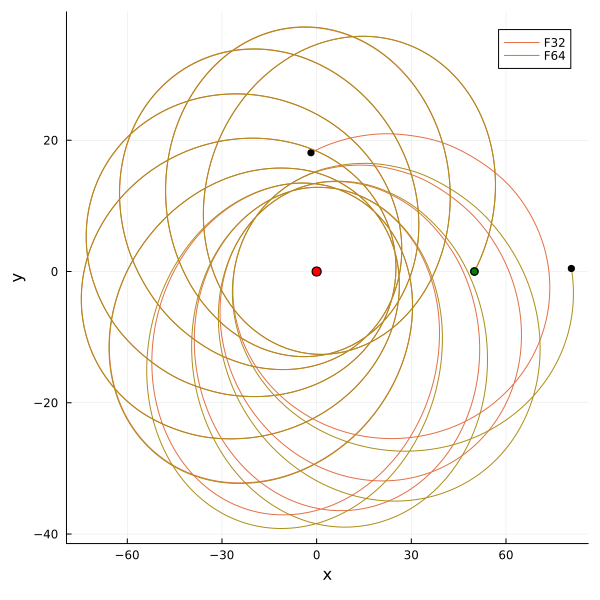

In [18]:
using Plots
import Parameters: @unpack
@unpack a = modelF64.parameters    #Get the BH spin parameter 

#Interpolate to higher resolution for smooth plotting   
interpolation_factor = 10 

Tend = min(last(solutionF64.t),last(solutionF32.t))
len = length(solutionF64.t)*interpolation_factor

Tspan = range(first(solutionF64.t),Tend,length=len)
p64  = solutionF64(Tspan)
p32  = solutionF32(Tspan)

xBH = 0:0; yBH = 0:0
plt = scatter(xBH, yBH,markercolor="red",markersize=5,size = (600, 600),xlabel='x', ylabel='y',label="")

labels = ["F32", "F64"]
i = 1
for p in [p32,p64]

    r = p[2,:]
    θ = p[3,:] 
    ϕ = p[4,:]

    # Boyer lindquist to Cartesian 
    w = sqrt.(r.^2 .+ a^2) 
    x = w .* sin.(θ) .* cos.(ϕ)
    y = w .* sin.(θ) .* sin.(ϕ)
    z = r .* cos.(θ)


    plt = plot!(x,y,label=labels[i])       
    plt = scatter!(first(x):first(x), first(y):first(y),markercolor = "green",label="") # The start point
    plt = scatter!(last(x):last(x), last(y):last(y),markercolor = "black",label="")     #The end point 
    i+=1

end 
display(plt)


## 3. Automatic Differentiation 

`RelativisticDynamics.jl` is written so as to be generally differentiable by the [differentiation tools in Julia](https://juliadiff.org/).

Specifically, we have been working using [Enzyme.jl](https://github.com/EnzymeAD/Enzyme.jl).

Let's see how this works by considering how the numerical solution varies with eccentricity. That is, want to calculate

$$\frac{\partial L}{\partial e} $$

where $L$ is some general loss function which depends on the output of `orbit()`.


To define our loss function, lets first get a reference solution:


In [16]:
# Get a reference solution.
# We will use this to define a gradient 
reference_solution,reference_model = orbit(Norbits=1); #using the default parameters

THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out


Given this reference solution, we define some arbitrary loss that compares the difference in the final value of the $r$-coordinate at the end of the integration.

In [17]:
function loss_function(reference,e)

    # Run the model using the new value of e
    solution,model = orbit(e=e,Norbits=1)
    

    r0 = last(reference[2,:])  # The last r value of the reference solution
    r = last(solution[2,:])    # The last r value of the new solution
    loss = abs(r0 - r)         # Loss
  
    return loss

end

loss_function (generic function with 1 method)

We can explore explicitly how this loss function varies with $e$:

In [18]:
N = 20 #number of samples
loss_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))

    loss = loss_function(reference_solution,v)
    loss_data[i,1] = v 
    loss_data[i,2] = loss

end

THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution


out
THIS IS A TEST
System params
bounds check
constnat
MODEL
initial_conditions.jl
solution
out


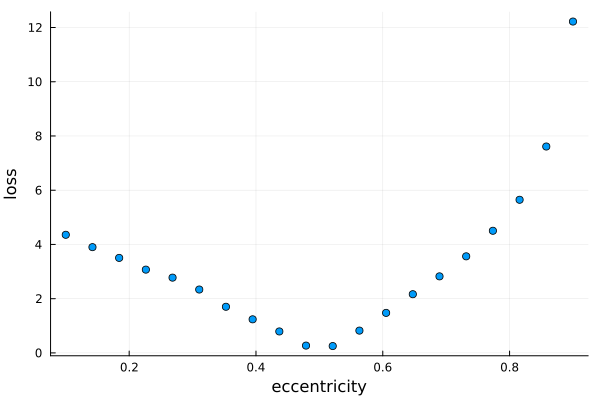

In [19]:
scatter(loss_data[:,1], loss_data[:,2],legend=false,
        xlabel = "eccentricity",
        ylabel = "loss") # eccentricity vs loss 

Ok that makes sense - the loss is minimal at $e=0.5$ which is the value used in the reference solution and then diverges at low/high $e$.

Now, suppose we have the reference solution, but we don't know the eccentricity.

We can guess some at some eccentricity and see how the solution compares to the reference i.e. calculate the loss.

But given this loss what do we do next? Guess a higher $e$? Lower $e$? By how much do we increase/decrease $e$? This is a classic optimization problem that - if we had a gradient - could be trivially solved by gradient descent. 

However, using AD we can also get the gradient of the solution!


## TODO: working example using ENZYME


In [21]:
`import Pkg; Pkg.add("Enzyme")`

LoadError: LoadError: parsing command `import Pkg; Pkg.add("Enzyme")`: special characters "#{}()[]<>|&*?~;" must be quoted in commands
in expression starting at /Users/t1/github_repos/RelativisticDynamics.jl/notebooks/demo.ipynb:1

In [23]:
import Pkg; Pkg.add("Enzyme")

   Resolving package versions...


   Installed EnzymeCore ─── v0.3.0


   Installed Enzyme_jll ─── v0.0.57+0


   Installed TimerOutputs ─ v0.5.23
   Installed GPUCompiler ── v0.19.4
   Installed Enzyme ─────── v0.11.1


    Updating `~/github_repos/RelativisticDynamics.jl/Project.toml`
  [7da242da] + Enzyme v0.11.1
    Updating `~/github_repos/RelativisticDynamics.jl/Manifest.toml`


  [7da242da] + Enzyme v0.11.1
  [f151be2c] + EnzymeCore v0.3.0
⌅ [61eb1bfa] + GPUCompiler v0.19.4
⌅ [d8793406] + ObjectFile v0.3.7
  [53d494c1] + StructIO v0.3.0
  [a759f4b9] + TimerOutputs v0.5.23
⌅ [7cc45869] + Enzyme_jll v0.0.57+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`


Precompiling 

project...


  ✓ EnzymeCore


  ✓ Enzyme_jll


  ✓ TimerOutputs


  ✓ GPUCompiler


  ✓ Enzyme


  ✗ RelativisticDynamics
  5 dependencies successfully precompiled in 108 seconds. 290 already precompiled.
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


In [24]:
using Enzyme 

In [25]:
using Enzyme 


#Enzyme.gradient = gradient(Forward, loss_function, reference_solution, 0.2)
 


Enzyme.autodiff(Forward, loss_function, Duplicated, reference_solution,Duplicated(0.2,1.0))


#.gradient(x -> loss_function(reference_solution,x),v)[1]


┌ Warning: TypeAnalysisDepthLimit
│ {[]:Pointer, [0]:Pointer, [0,0]:Pointer, [0,0,0]:Pointer, [0,0,0,0]:Pointer, [0,0,0,0,0]:Pointer, [0,0,0,0,0,-1]:Float@double, [0,0,0,0,8]:Integer, [0,0,0,0,9]:Integer, [0,0,0,0,10]:Integer, [0,0,0,0,11]:Integer, [0,0,0,0,12]:Integer, [0,0,0,0,13]:Integer, [0,0,0,0,14]:Integer, [0,0,0,0,15]:Integer, [0,0,0,0,16]:Integer, [0,0,0,0,17]:Integer, [0,0,0,0,18]:Integer, [0,0,0,0,19]:Integer, [0,0,0,0,20]:Integer, [0,0,0,0,21]:Integer, [0,0,0,0,22]:Integer, [0,0,0,0,23]:Integer, [0,0,0,0,24]:Integer, [0,0,0,0,25]:Integer, [0,0,0,0,26]:Integer, [0,0,0,0,27]:Integer, [0,0,0,0,28]:Integer, [0,0,0,0,29]:Integer, [0,0,0,0,30]:Integer, [0,0,0,0,31]:Integer, [0,0,0,0,32]:Integer, [0,0,0,0,33]:Integer, [0,0,0,0,34]:Integer, [0,0,0,0,35]:Integer, [0,0,0,0,36]:Integer, [0,0,0,0,37]:Integer, [0,0,0,0,38]:Integer, [0,0,0,0,39]:Integer, [0,0,0,0,40]:Integer, [0,0,8]:Integer, [0,0,9]:Integer, [0,0,10]:Integer, [0,0,11]:Integer, [0,0,12]:Integer, [0,0,13]:Integer, [0,0,14

In [8]:
using Enzyme 

loss_gradient_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss_g = Zygote.gradient(x -> loss_function(reference_solution,x),v)[1]
    loss_gradient_data[i,1] = v 
    loss_gradient_data[i,2] = loss_g
end

UndefVarError: UndefVarError: N not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


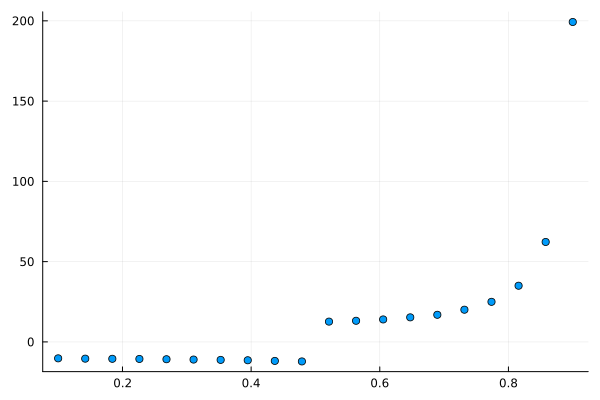

In [27]:
scatter(loss_gradient_data[:,1], loss_gradient_data[:,2],legend=false) # eccentricity vs gradient 

In [ ]:

# """
#     PlotTrajectory(solution,model,dimensions=[1,2,3],savepath="")
# Plot trajectory of a body. Assumes coordinates are Boyer Lindquist. 
# Plots in either 2D or 3D depending on specification of dimensions.
# Saves a low resolution PNG figure to disk in example_media/
# """
# function PlotTrajectory(solution,model,dimensions=[1,2,3],savepath="")

#     @unpack a = model.parameters    #Get the BH spin parameter 
    
#     println("Plotting the solution generated with the below user-defined parameters")
#     println(model.parameters)
#     println("-------------------------------")

#     #Interpolate to higher resolutiona for smooth plotting   
#     interpolation_factor = 10 
#     T = range(first(solution.t),last(solution.t),length=length(solution.t)*interpolation_factor)
#     p = solution(T)

#     # Extract relevant data from the interpolated solution 
#     r = p[2,:]
#     θ = p[3,:] 
#     ϕ = p[4,:]

#     # Boyer lindquist to Cartesian 
#     w = sqrt.(r.^2 .+ a^2) 
#     x = w .* sin.(θ) .* cos.(ϕ)
#     y = w .* sin.(θ) .* sin.(ϕ)
#     z = r .* cos.(θ)
#     position = [x,y,z]
#     position_labels = [L"x (r_h)",L"y (r_h)",L"z (r_h)"]


#     #Setup plotting env
#     if length(dimensions) == 3
        
#         plot(x,y,z,
#             legend=false,
#             xlabel=position_labels[1],
#             ylabel=position_labels[2],
#             zlabel=position_labels[3],
#             camera = (25, 30),
#             size = (1000, 600))


#         xBH = 0:0; yBH = 0:0; zBH = 0:0
#         scatter!(xBH, yBH,zBH,markercolor="red",markersize=5) 

#     elseif length(dimensions) == 2
#         idx1,idx2 = dimensions 
#         plt = plot(position[idx1],position[idx2],
#              xlabel=position_labels[idx1],
#              ylabel=position_labels[idx2],
#              legend=false,
#              size = (600, 600)
#              )

#         xBH = 0:0; yBH = 0:0
#         plt = scatter!(xBH, yBH,markercolor="red",markersize=5)

#     else
#         println("Those dimensions are not defined")
#         return

#     end

#     display(plt)
#     if ~isempty(savepath)
#         println("Saving figure to: ", savepath)
#         savefig(savepath)
#     end



# end 


# """
#     StackedPlot(solution,model,savepath="")
# Plot the x-y and x-z trajectory of a body on two separate subplots
# """
# function StackedPlot(solution,model,savepath="")


#     #Interpolate to higher resolution for smooth plotting   
#     @unpack a = model.parameters    #Get the BH spin parameter 

#     interpolation_factor = 10 
#     T = range(first(solution.t),last(solution.t),length=length(solution.t)*interpolation_factor)
#     p = solution(T)

#     # Extract relevant data from the interpolated solution 
#     r = p[2,:]
#     θ = p[3,:] 
#     ϕ = p[4,:]

#     # Boyer lindquist to Cartesian 
#     w = sqrt.(r.^2 .+ a^2) 
#     x = w .* sin.(θ) .* cos.(ϕ)
#     y = w .* sin.(θ) .* sin.(ϕ)
#     z = r .* cos.(θ)
    

#     #Convert to km in the z-direction
#     mBH = model.parameters.mBH
#     c   = model.constant.light_c
#     μ   = model.constant.μ
   
#     factor = mBH*μ/c^2
#     z_km = z * factor/1e3


#     #x-y 
#     plot(x,y,layout=grid(2,1, heights=(0.8,0.2)), size=(450,600),legend=false,link = :x)
#     plot!(ylabel=L"y (r_h)",subplot=1)



#     xBH = 0:0; yBH = 0:0
#     plt = scatter!(xBH, yBH,markercolor="red",markersize=5,subplot=1)

#     #x-z
#     plot!(x,z_km,subplot=2,legend=false)
#     plot!(xlabel=L"x \rm (r_h)",subplot=2)
#     plot!(ylabel=L"z (km)",subplot=2)


#     display(plt)
#     if ~isempty(savepath)
#         println("Saving figure to: ", savepath)
#         savefig(savepath)
#     end



# end 

